# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
# Your code here:
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

In [5]:
#Option B
sensor.isnull().any()

attitude.roll         False
attitude.pitch        False
attitude.yaw          False
gravity.x             False
gravity.y             False
gravity.z             False
rotationRate.x        False
rotationRate.y        False
rotationRate.z        False
userAcceleration.x    False
userAcceleration.y    False
userAcceleration.z    False
dtype: bool

In [23]:
#Option C
sensor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1751 entries, 2018-01-01 00:00:00 to 2018-01-01 00:29:10
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   attitude.roll       1751 non-null   float64       
 1   attitude.pitch      1751 non-null   float64       
 2   attitude.yaw        1751 non-null   float64       
 3   gravity.x           1751 non-null   float64       
 4   gravity.y           1751 non-null   float64       
 5   gravity.z           1751 non-null   float64       
 6   rotationRate.x      1751 non-null   float64       
 7   rotationRate.y      1751 non-null   float64       
 8   rotationRate.z      1751 non-null   float64       
 9   userAcceleration.x  1751 non-null   float64       
 10  userAcceleration.y  1751 non-null   float64       
 11  userAcceleration.z  1751 non-null   float64       
 12  date                1751 non-null   datetime64[ns]
dtypes: datetime6

- There are no null values, so there's no need to remove rows containing missing data

How many rows and columns are in our data?

In [6]:
# Your code here:
sensor.shape

(1751, 12)

- There are 1751 rows and 12 columns

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
# Your code here:
pd.date_range(start="1/1/2018 00:00:00", end="1/1/2018 00:29:10", periods=1751)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

### Correction

In [24]:
dates = pd.date_range(start="1/1/2018 00:00:00", end="1/1/2018 00:29:10", periods=sensor.shape[0])
sensor.index = pd.DatetimeIndex(dates, freq="infer")

Assign the time series index to the dataframe's index.

In [8]:
# Your code here:
sensor["date"] = pd.date_range(start="1/1/2018 00:00:00", end="1/1/2018 00:29:10", periods=1751)

In [9]:
sensor.index = sensor["date"]

In [10]:
sensor.head(3)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,date
date,,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,2018-01-01 00:00:00
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,2018-01-01 00:00:01
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,2018-01-01 00:00:02


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [27]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [12]:
# Your code here:
res = sm.tsa.seasonal_decompose(sensor['userAcceleration.x'],
                                period=60,
                                model='additive')

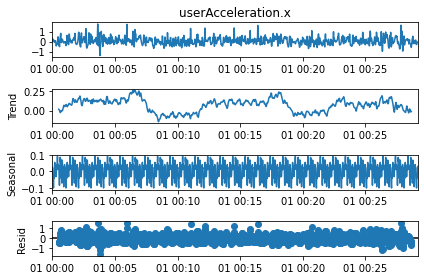

In [13]:
res.plot();

### Correction

In [26]:
res_ = seasonal_decompose(sensor['userAcceleration.x'],period=60)   #por defecto, seasonal_decompose es aditivo

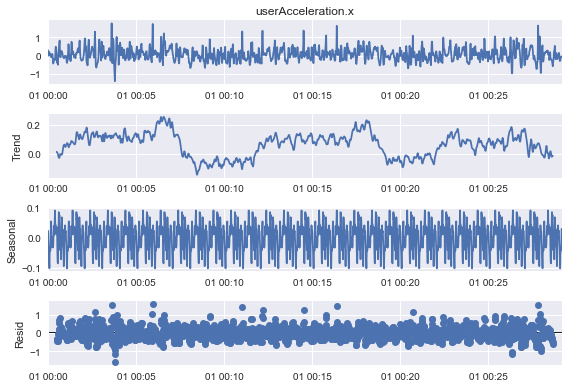

In [31]:
#Option B
plt.style.use("seaborn")

res_.plot();

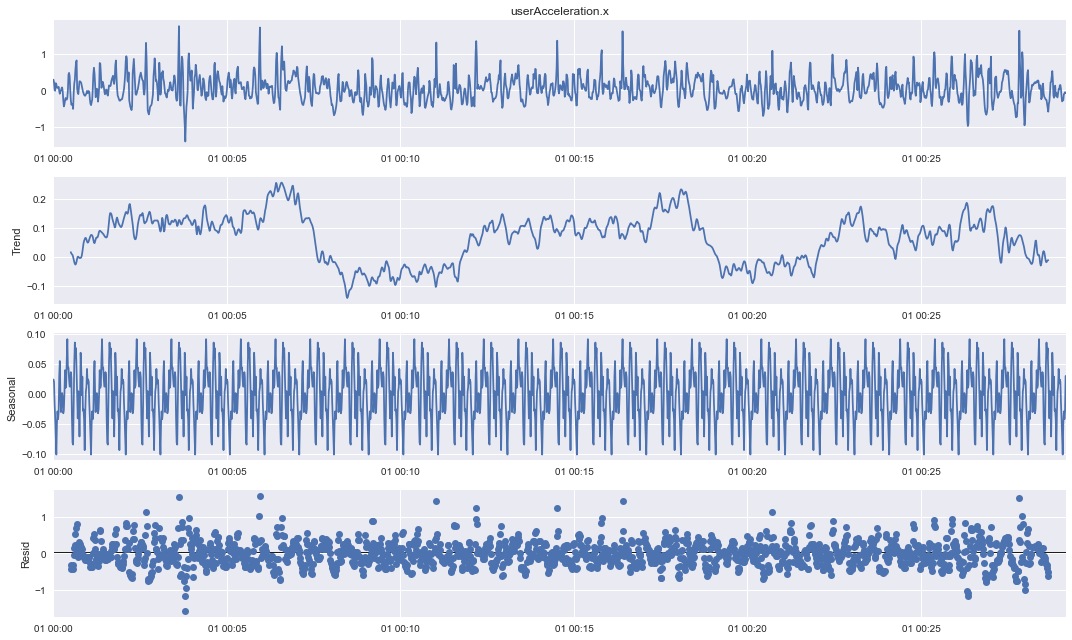

In [35]:
#Option C
from pylab import rcParams

rcParams['figure.figsize'] = 15, 9

res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

In [14]:
res2 = sm.tsa.seasonal_decompose(sensor['rotationRate.x'],
                                period=60,
                                model='additive')

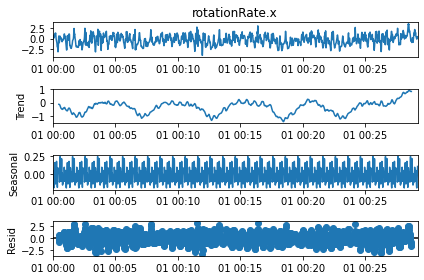

In [15]:
res2.plot();

### Correction

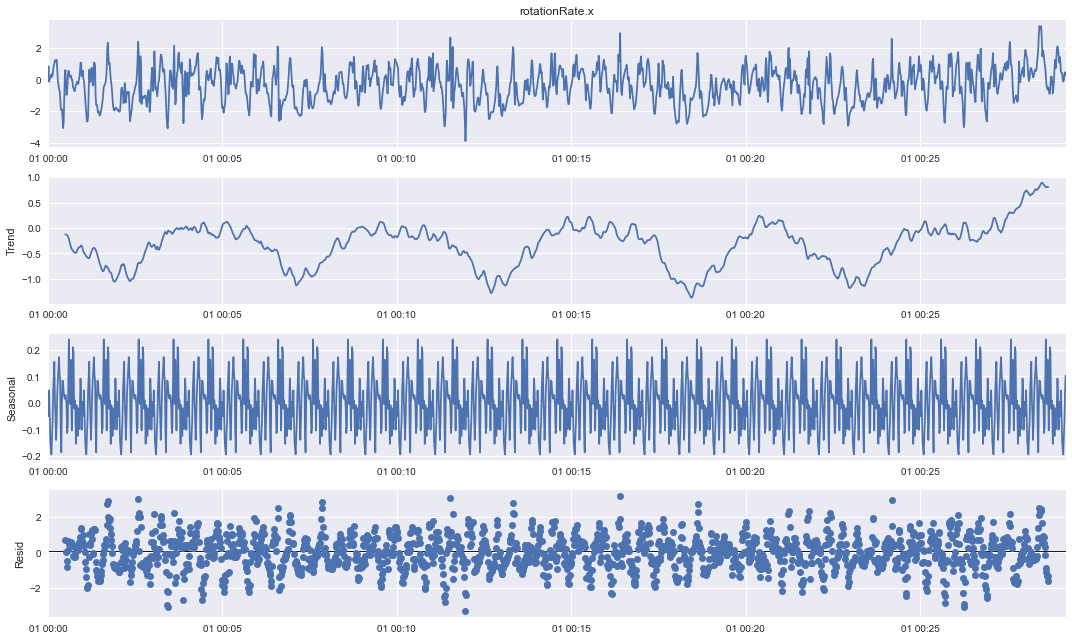

In [36]:
rcParams['figure.figsize'] = 15, 9

res2.plot();

In [40]:
from scipy.fft import fft, fftfreq, fftshift

<ipython-input-39-88aa2cff1beb>:1: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  fourier = fft(sensor['userAcceleration.x'].values)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


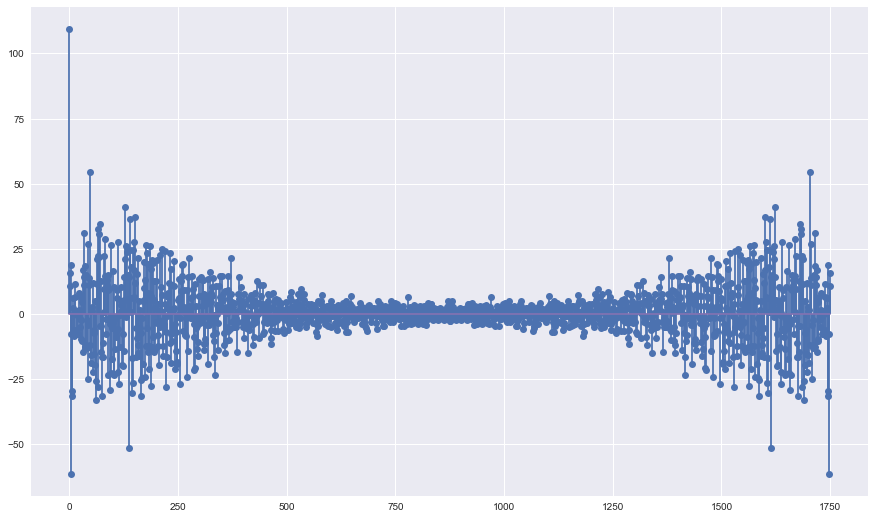

In [39]:
fourier = fft(sensor['userAcceleration.x'].values)
plt.stem(fourier);

In [43]:
signal = sensor['userAcceleration.x'].values

ft = fft(signal)
sp = fftshift(ft)
freq = fftshift(fftfreq(len(signal)))
fourier = pd.DataFrame({"freq":freq, "value":sp.real})
fourier.head()

,freq,value
0,-0.499714,-2.640188
1,-0.499143,-0.165664
2,-0.498572,3.314038
3,-0.498001,2.860497
4,-0.497430,0.987010


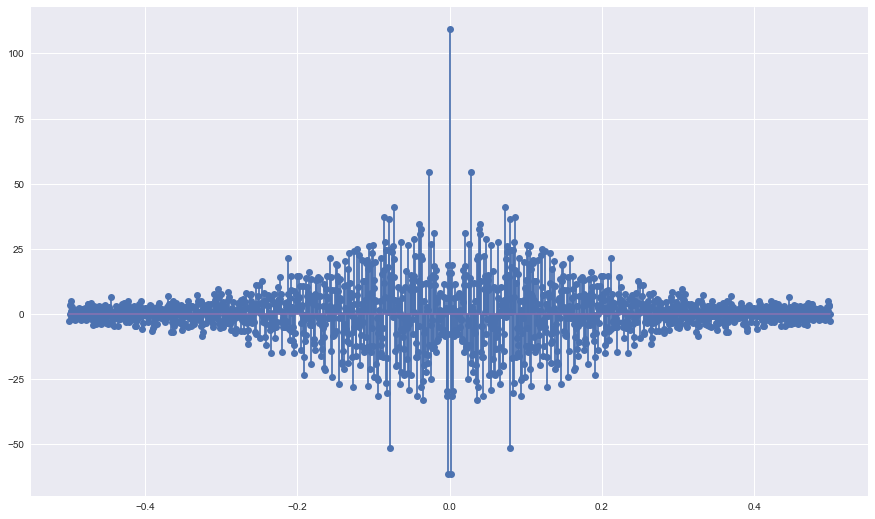

In [44]:
plt.stem(fourier.freq, fourier.value);

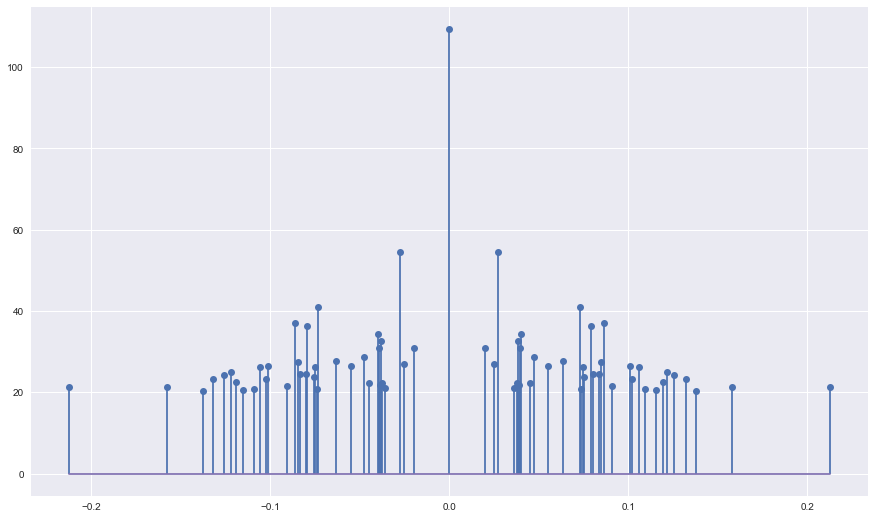

In [45]:
f = fourier[fourier.value > 20]      #para ver frecuencias mayores de 20 unicamente
plt.stem(f.freq, f.value);

- La frecuencia en 0.0 indica que hay una constante en la señal

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

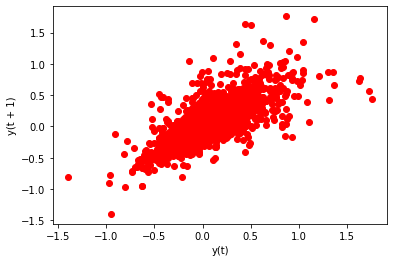

In [16]:
# Your code here:
pd.plotting.lag_plot(sensor['userAcceleration.x'], c = 'red');

Create a lag plot for `rotationRate.x`

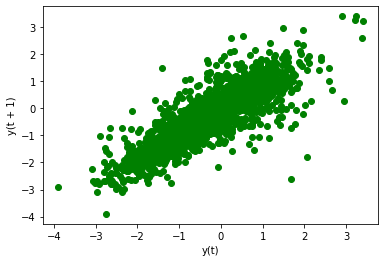

In [17]:
# Your code here:
pd.plotting.lag_plot(sensor['rotationRate.x'], c = 'green');

What are your conclusions from both visualizations?

In [18]:
# Your conclusions here:

We can draw multiple conclusions from these 2 plots:
- The first one (red) is way more dispersed and wide distributed than the second
- The second plot is more largely distributed than the first one, meaning that is covers a larger range of data

### Correction

In [47]:
rcParams['figure.figsize'] = [7,7]

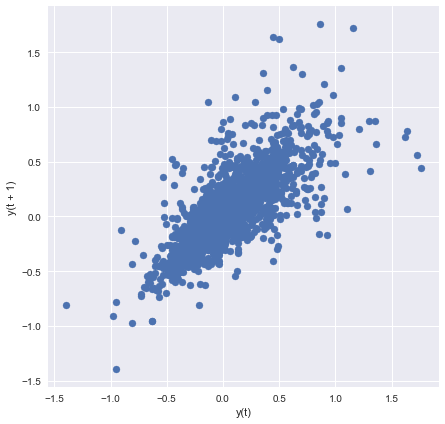

In [48]:
pd.plotting.lag_plot(sensor['userAcceleration.x']);

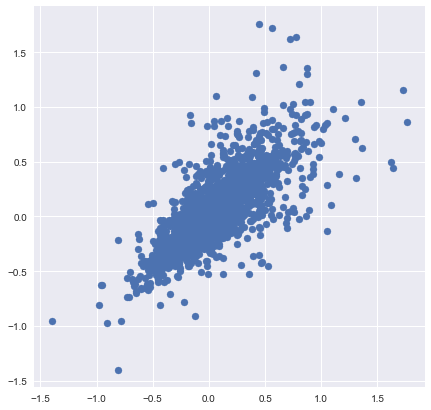

In [49]:
f_t = sensor['userAcceleration.x'].iloc[1:]     #funcion en relacion al tiempo
f_t_minus_1 = sensor['userAcceleration.x'].iloc[:-1]
plt.scatter(f_t, f_t_minus_1);

- el **lagplot** da informacion sobre la continuidad y la falta de saltos de los valores

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [19]:
# Your code here:



What are your conclusions from this test?

In [20]:
# Your conclusions here:



Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [51]:
from statsmodels.tsa.arima_model import ARIMA

In [21]:
# Your code here:



To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [22]:
# Your code here:

